# Классификация и линейная регрессия со scikit-learn

## Часть 2. Алгоритм к-ближайших соседей.

kNN расшифровывается как k Nearest Neighbor или k Ближайших Соседей — это один из самых простых алгоритмов классификации, также иногда используемый в задачах регрессии.

### Описание метода

Описание метода представлено здесь:

* RUS: [Алгоритм k-ближайших соседей // Основы машинного обучения](https://youtu.be/2ufg0G-0RRc)
* RUS: [Алгоритм K-ближайших соседей в Python и Scikit-Learn](https://pythobyte.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn-31cdde4d/)
* RUS: [Алгоритм k-ближайших соседей](http://datascientist.one/k-nearest-neighbors-algorithm/)
* RUS: [Основные метрики задач классификации в машинном обучении](https://webiomed.ai/blog/osnovnye-metriki-zadach-klassifikatsii-v-mashinnom-obuchenii/)
* RUS: [Классификатор kNN](https://habr.com/ru/post/149693/)
* ENG: [Обучение модели машинного обучения с помощью перекрестной проверки](https://docs.microsoft.com/ru-ru/dotnet/machine-learning/how-to-guides/train-machine-learning-model-cross-validation-ml-net)
* ENG: [Разница между K-средним и K-ближайшим соседом](http://www.devcoons.com/difference-k-means-k-nearest-neighbor-algorithm/)
* RUS: [Метод k-ближайших соседей (K-nearest neighbor)](https://wiki.loginom.ru/articles/k-nearest-neighbor.html)

In [ ]:
!pip install kaggle

В ячейке ниже загружаем kaggle.json для вашей среды выполнения Colab, полученный на https://www.kaggle.com/.



In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


### Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
1. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
1. С использованием метода `train_test_split` разделите выборку на обучающую и тестовую.
1. Обучите модель ближайших соседей для произвольно заданного гиперпараметра `K`. Оцените качество модели с помощью трех подходящих для задачи метрик.
1. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
1. Произведите подбор гиперпараметра `K` с использованием `GridSearchCV` и кросс-валидации.
1. Повторите пункт 4 для найденного оптимального значения гиперпараметра `K`. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
1. Постройте кривые обучения и валидации.


### Выбор датасета

Для самостоятельной работы предлагается выбрать один из датасетов

* [Glass Classification](https://www.kaggle.com/uciml/glass)

* [Iris Flower Dataset](https://www.kaggle.com/arshid/iris-flower-dataset)

В данном блокноте рассматривается [Classifying wine varieties](https://www.kaggle.com/brynja/wineuci).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_curve,confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

# 'Магическая' функция matplotlib
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

Получаем датасет:

In [ ]:
!cd /content/
!mkdir wineuci
!cd /content/wineuci

mkdir: cannot create directory ‘wineuci’: File exists


In [ ]:
!kaggle datasets download -d brynja/wineuci -p /content/wineuci

wineuci.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/wineuci/wineuci.zip -d /content/wineuci

Archive:  /content/wineuci/wineuci.zip
replace /content/wineuci/Wine.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/wineuci/Wine.csv  


### Загрузка набора данных

In [ ]:
CURENT_DIR = '/content/wineuci'

In [ ]:
# Загрузить набор данных
data = pd.read_csv(CURENT_DIR+'/Wine.csv', delimiter=',', encoding = "ISO-8859-1", 
                     names = ('Class','Alcohol','Malic acid','Ash','Alcalinity of ash',
                                'Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols',
                                'Proanthocyanins','Color intensity','Hue','OD','Proline')) 

# Распечать первые 5 строк фрейма данных
data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Первичный осмотр выбранного датасета

In [ ]:
# Список колонок с типами данных
data.dtypes

Class                     int64
Alcohol                 float64
Malic acid              float64
Ash                     float64
Alcalinity of ash       float64
Magnesium                 int64
Total phenols           float64
Flavanoids              float64
Nonflavanoid phenols    float64
Proanthocyanins         float64
Color intensity         float64
Hue                     float64
OD                      float64
Proline                   int64
dtype: object

In [ ]:
for col in data.columns:
    print('{} - {}'.format(col, data[data[col].isnull()].shape[0]))

Class - 0
Alcohol - 0
Malic acid - 0
Ash - 0
Alcalinity of ash - 0
Magnesium - 0
Total phenols - 0
Flavanoids - 0
Nonflavanoid phenols - 0
Proanthocyanins - 0
Color intensity - 0
Hue - 0
OD - 0
Proline - 0


In [ ]:
data.shape 

(178, 14)

### Разделяем тестовые и данные для обучения

In [ ]:
X = data.drop('Class',axis=1).values
y = data['Class'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)
print('X_train: {}  y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test: {}  y_test: {}'.format(X_test.shape, y_test.shape))

X_train: (124, 13)  y_train: (124,)
X_test: (54, 13)  y_test: (54,)


### Обучение модели ближайших соседей

**Оптимизация гиперпараметров** — задача машинного обучения по выбору набора оптимальных гиперпараметров для обучающего алгоритма.

Одни и те же виды моделей машинного обучения могут требовать различные предположения, веса или скорости обучения для различных видов данных. Эти параметры называются гиперпараметрами и их следует настраивать так, чтобы модель могла оптимально решить задачу обучения.




In [ ]:
# Настройка массивов для хранения точности обучения и тестирования
neighbors = np.arange(1,14)
len(neighbors) 

13

### Обучение при различном количестве соседей

In [ ]:
# Вернуть новый массив заданной формы и типа без инициализации записей.
# При первом вызове функции все элементы окажутся случайными:
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Настройка классификатора Knn с K соседями
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Обучить модель
    knn.fit(X_train, y_train)
    
    # Вычислить точность на тренировочном наборе
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Вычислить точность на тестовом наборе
    test_accuracy[i] = knn.score(X_test, y_test)

In [ ]:
# Построить набор
plt.title('k-NN Различное количество соседей')
plt.plot(neighbors, train_accuracy, label='Точность на обучающем наборе')
plt.plot(neighbors, test_accuracy, label='Точность на тестовом наборе')
plt.legend()
plt.xlabel('Количество соседей')
plt.ylabel('Точность')
plt.show()

### Изучение работы KNeighborsClassifier



Классификатор, реализующий голосование ближайших соседей.

In [ ]:
# Настройка классификатора knn с K соседями. Указываем искать 10 групп-соседей
knn = KNeighborsClassifier(n_neighbors=10)

In [ ]:
# Обучаем модель
knn.fit(X_train,y_train)

In [ ]:
# Приведет для примера:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [ ]:
# Получить точность. Примечание: в случае алгоритмов классификации метод оценки представляет собой точность.
knn.score(X_test,y_test)

См подробнее об [Precision, recall и F-мера](https://habr.com/ru/company/ods/blog/328372/).

In [ ]:
from sklearn.metrics import classification_report

# precision - точность 
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.88      0.83      0.86        18
           2       0.87      0.62      0.72        21
           3       0.50      0.73      0.59        15

    accuracy                           0.72        54
   macro avg       0.75      0.73      0.72        54
weighted avg       0.77      0.72      0.73        54



### Точность

In [ ]:
cl1_1 = KNeighborsClassifier(n_neighbors=7)
cl1_1.fit(X_train, y_train)
target1_1 = cl1_1.predict(X_test)
accuracy_score(y_test, target1_1)

0.7407407407407407

In [ ]:
y_pred = knn.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,All
True,,,,
1,15,0,3,18
2,0,13,8,21
3,2,2,11,15
All,17,15,22,54


### ROC-кривая



ROC-кривая (Receiver Operator Characteristic) – кривая, которая наиболее часто используется для представления результатов бинарной классификации в машинном обучении. Название пришло из систем обработки сигналов. Поскольку классов два, один из них называется классом с положительными исходами, второй – с отрицательными исходами. ROC-кривая показывает зависимость количества верно классифицированных положительных примеров от количества неверно классифицированных отрицательных примеров. В терминологии ROC-анализа первые называются истинно положительным, вторые – ложно отрицательным множеством. При этом предполагается, что у классификатора имеется некоторый параметр, варьируя который, мы будем получать то или иное разбиение на два класса. Этот параметр часто называют порогом, или точкой отсечения (cut-off value). В зависимости от него будут получаться различные величины ошибок I и II рода.

Подробнее см. [здесь](https://basegroup.ru/community/articles/logistic).

И еще см. [здесь](https://habr.com/ru/post/228963/), тут понятнее.



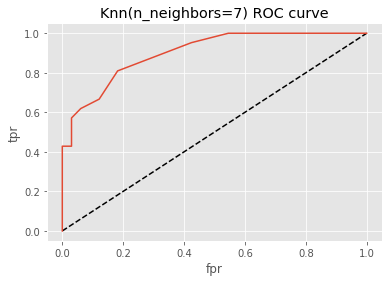

In [ ]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=2)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=7) ROC curve')
plt.show()

### Кросс-валидация

[Кросс-валидация](https://neerc.ifmo.ru/wiki/index.php?title=Кросс-валидация)

[Перекрестная проверка K-Fold - Введение в машинное обучение](https://youtu.be/TIgfjmp-4BA)

In [ ]:
param_grid = {'n_neighbors':np.arange(1,14)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])})

`GridSearchCV` – это очень мощный инструмент для автоматического подбирания параметров для моделей машинного обучения. GridSearchCV находит наилучшие параметры, путем обычного перебора: он создает модель для каждой возможной комбинации параметров. Важно отметить, что такой подход может быть весьма времязатратным.

Подробнее [здесь](https://vc.ru/ml/147132-kak-avtomaticheski-podobrat-parametry-dlya-modeli-mashinnogo-obucheniya-ispolzuem-gridsearchcv).

In [ ]:
 GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       n_jobs=None,
       param_grid=param_grid,
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])},
             return_train_score='warn')

In [ ]:
knn_cv.best_score_ 

0.727

In [ ]:
knn_cv.best_params_ 

{'n_neighbors': 4}

### K-fold

[Разновидности скользящего контроля](http://www.machinelearning.ru/wiki/index.php?title=CV)




Данная стратегия работает в соответствии с определением кросс-валидации.

Каждой стратегии в `scikit-learn` ставится в соответствии специальный класс-итератор, который может быть указан в качестве параметра cv функций `cross_val_score` и `cross_validate`.

In [ ]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=4), 
                         X, y, 
                         cv=KFold(n_splits=5))

# Значение метрики accuracy для 5 фолдов
scores

array([0.86111111, 0.77777778, 0.61111111, 0.71428571, 0.        ])

In [ ]:
# Усредненное значение метрики accuracy для 5 фолдов
np.mean(scores) 

0.5928571428571429

In [ ]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

scores = cross_validate(KNeighborsClassifier(n_neighbors=4), 
                        X, y, scoring=scoring, 
                        cv=KFold(n_splits=5), return_train_score=True)
scores

{'fit_time': array([0.00125766, 0.00074196, 0.00076842, 0.00071883, 0.00075102]),
 'score_time': array([0.00822878, 0.00396776, 0.00394273, 0.00436521, 0.00399184]),
 'test_f1': array([0.92537313, 0.86944752, 0.75862069, 0.71080409, 0.        ]),
 'test_precision': array([1.        , 1.        , 1.        , 0.72533333, 0.        ]),
 'test_recall': array([0.86111111, 0.77777778, 0.61111111, 0.71428571, 0.        ]),
 'train_f1': array([0.82296931, 0.80124489, 0.84424307, 0.7894962 , 0.87128745]),
 'train_precision': array([0.82446207, 0.80090285, 0.84426486, 0.79604422, 0.87889383]),
 'train_recall': array([0.82394366, 0.8028169 , 0.84507042, 0.7972028 , 0.88111888])}

### Leave One Out (LOO)



В тестовую выборку помещается единственный элемент (One Out). Количество фолдов в этом случае определяется автоматически и равняется количеству элементов.

Данный метод более ресурсоемкий чем KFold.

Существует эмпирическое правило, что вместо Leave One Out лучше использовать KFold на 5 или 10 фолдов.

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(X)

for train_index, test_index in loo.split(X):
   y_train, y_test = y[train_index], y[test_index]

### Repeated K-Fold


In [ ]:
scores2 = cross_val_score(KNeighborsClassifier(n_neighbors=4), 
                         X, y, 
                         cv=RepeatedKFold(n_splits=5, n_repeats=2))
scores2

array([0.63888889, 0.69444444, 0.61111111, 0.71428571, 0.68571429,
       0.72222222, 0.72222222, 0.61111111, 0.62857143, 0.65714286])

### Обучение с оптимальным K

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7407407407407407

### Построение кривых обучения

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

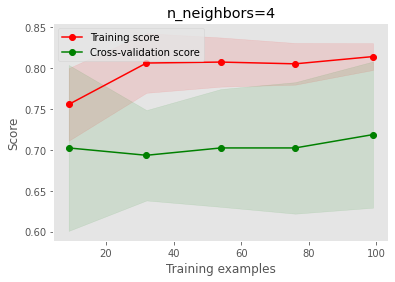

In [ ]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=4), 'n_neighbors=4', 
                    X_train, y_train, cv=5)

### Построение кривой валидации

In [ ]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

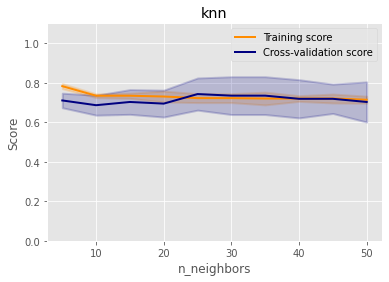

In [ ]:
n_range = np.array(range(5,55,5))
plot_validation_curve(KNeighborsClassifier(n_neighbors=4), 'knn', 
                      X_train, y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=5, scoring="accuracy")